## CIFAR - 10 dataset

Source: http://www.cs.toronto.edu/~kriz/cifar.html

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. |

In [1]:
import os
import pickle
import random
import tarfile as tar
from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torchvision
from PIL import Image
from torchinfo import summary

import torch
from functions import (
    extract_tarfile,
    get_class_names,
    get_classes,
    read_and_save_images,
    visualise_images,
)

# from model import VGG
from torch import nn

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
GENERATOR = torch.Generator().manual_seed(42)

In [3]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

In [4]:
# Since the dataset came in a gzip format, extracting the gzip file
root_dir = extract_tarfile(tarfile_path="data/cifar-10-python.tar.gz")

Path data\cifar-10-python already exists.
Extracting all the contents of the data\cifar-10-python.tar.gz file into data\cifar-10-python


In [5]:
class_names, idx_to_classes = get_class_names(root_dir=root_dir)
print("Class Names in the dataset: ", class_names)
print("Index to Class Mapping: ", idx_to_classes)

Class Names in the dataset:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Index to Class Mapping:  {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [5]:
# extracted all the images and saved them in the './train/{class_name}'
read_and_save_images(root_dir=root_dir)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
Creating 'train' directory at the path data\cifar-10-python\train
Creating 'test' directory at the path data\cifar-10-python\test


In [6]:
train_dir = root_dir / "train"
test_dir = root_dir / "test"

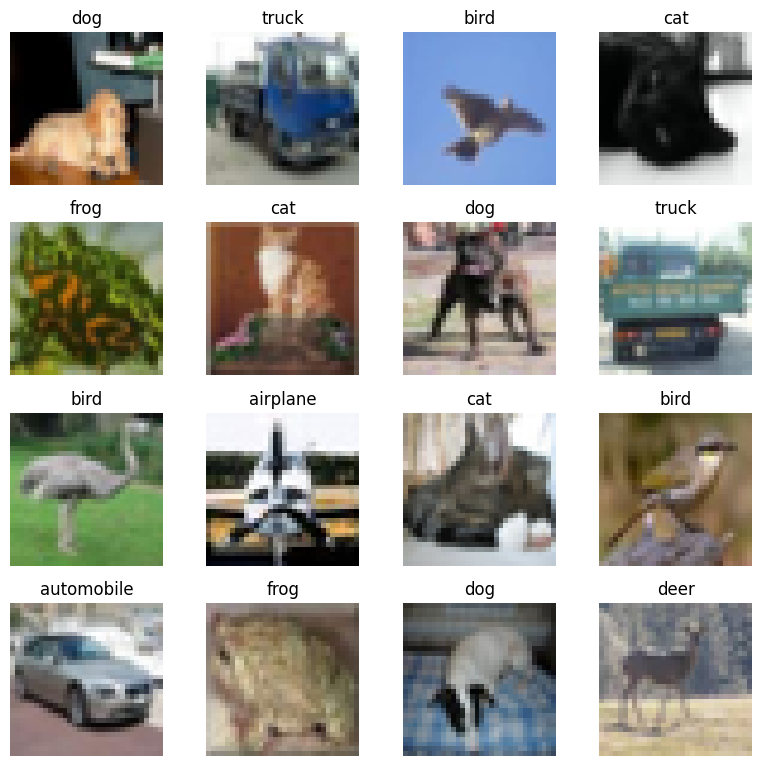

In [7]:
visualise_images(root_dir)

In [8]:
class Cifar10Dataset(torch.utils.data.Dataset):
    def __init__(self, target_dir: str, transform=None):
        self.root_dir = root_dir
        self.paths = list(target_dir.glob("*/*.png"))
        self.transform = transform
        self.class_names, self.class_to_idx = get_classes(target_dir)

    def load_image(self, index: int):
        image_path = self.paths[index]
        return Image.open(image_path)

    def __len__(self):
        return len(self.paths)

    # overwrite __getitem__() to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
        image = self.load_image(index)
        class_name = self.paths[
            index
        ].parent.name  # expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        # if transform is necesarry
        if self.transform:
            return self.transform(image), class_idx
        else:
            return image, class_idx  # no transform

In [9]:
# Let's look at trivialaugment transform
train_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.TrivialAugmentWide(
            num_magnitude_bins=31
        ),  # num_magnitude_bins denotes how intense the augmentation happens
        torchvision.transforms.ToTensor(),
    ]
)

test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
    ]
)

In [10]:
train_dataset = Cifar10Dataset(target_dir=train_dir, transform=train_transform)
test_dataset = Cifar10Dataset(target_dir=test_dir, transform=test_transform)

In [11]:
def display_random_images(
    dataset: torch.utils.data.Dataset,
    classes: List[str] = None,
    n: int = 10,
    display_shape: bool = True,
    seed: int = None,
):

    if n > 10:
        n = 10
        display_shape = False

    if seed:
        random.seed(seed)

    random_images_indices = random.sample(
        population=range(len(dataset)), k=n
    )  # get n number of random images from the dataset

    plt.figure(figsize=(20, 6))

    for i, target in enumerate(random_images_indices):
        target_image, target_label = dataset[target][0], dataset[target][1]
        target_image_adjust = torch.tensor(np.asarray(target_image)).permute(
            1, 2, 0
        )  # convert CHW to HWC
        plt.subplot(1, n, i + 1)
        plt.imshow(target_image_adjust)
        plt.axis("off")
        if class_names:
            title = f"Class: {classes[target_label]}"
            if display_shape:
                title += f"\nShape: {target_image_adjust.shape}"
        plt.title(title)

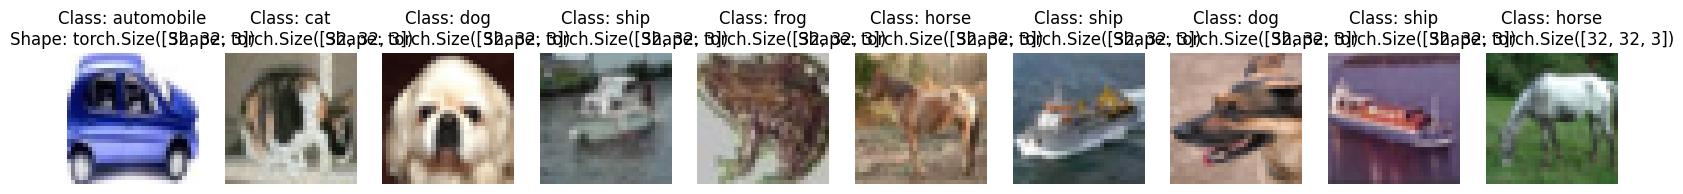

In [12]:
display_random_images(dataset=test_dataset, classes=class_names)

In [13]:
def plot_transformed_images(
    image_path_list, image_transform=None, n: int = 3, seed=None
):

    if seed:
        random.seed(seed)

    random_image_paths = random.sample(
        population=image_path_list, k=n
    )  # gives any 3 image paths from the list 'image_path_list'

    for image_path in random_image_paths:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 4))
        with Image.open(image_path) as image:
            ax[0].imshow(image)
            ax[0].set_title(f"Original\nSize: {image.size}")
            ax[0].axis("off")

            # matplotlib expects HWC format images whereas our image_transform converts to CHW format
            transformed_image = torch.tensor(
                np.asarray(image_transform(image))
            ).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

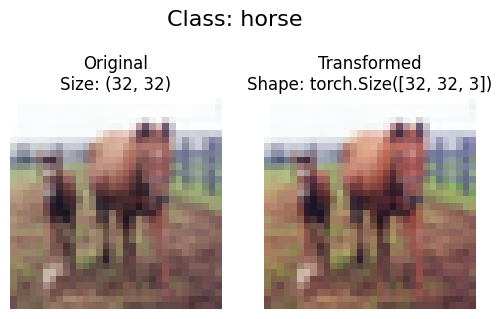

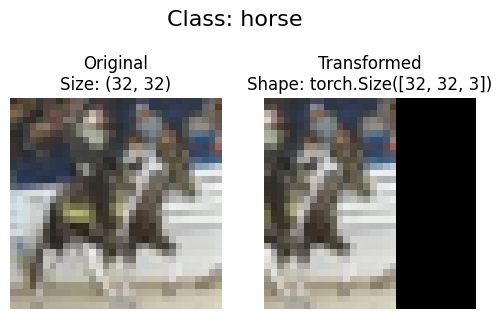

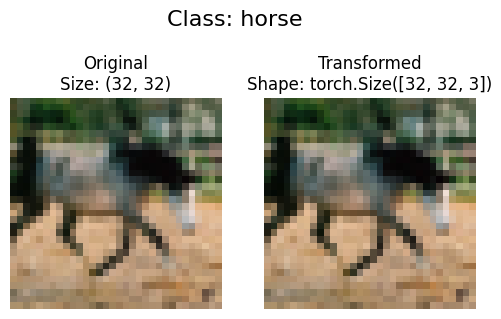

In [14]:
plot_transformed_images(
    image_path_list=train_dataset.paths, image_transform=train_transform
)

In [15]:
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS
)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS
)

In [ ]:
iter(train_dataloader)

In [17]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier_layer = nn.Sequential(
            nn.Flatten(), nn.Linear(hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        # below expression benefits from operator fusion
        return self.classifier_layer(self.conv_block_2(self.conv_block_1(x)))

In [18]:
model_VGG = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(
    DEVICE
)
summary(model_VGG)

Layer (type:depth-idx)                   Param #
TinyVGG                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       280
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       910
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       910
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       910
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Flatten: 2-11                     --
│    └─Linear: 2-12                      110
Total params: 3,120
Trainable params: 3,120
Non-trainable params: 0

In [ ]:
image, image_label = next(iter(train_dataloader))

In [ ]:
image.shape